In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def str_to_float(number):
    num = number.split(',')
    if len(num)==1 :
        return float(num[0])
    else :
        return (float(num[0]+'.'+num[1]))

str_to_float_v = np.vectorize(str_to_float)

In [5]:
def new_name(path,ext):
    componants = path.split("\\")
    name = componants[-1]
    name2 = name[:-4]
    return (name2 + "." + ext)

In [6]:
def plot_csv(path):
    data = pd.read_csv(path, index_col="Bal",delimiter=";")
    columns = data.columns
    data_to_plot = columns[2]
    
    val = str_to_float_v(data[data_to_plot].values)

    plt.figure()
    plt.plot(val)
    plt.xlabel("Balayage")
    plt.ylabel(data_to_plot)
    plt.grid()
    plt.savefig('Plot\\'+new_name(path,'png'))
    plt.show()

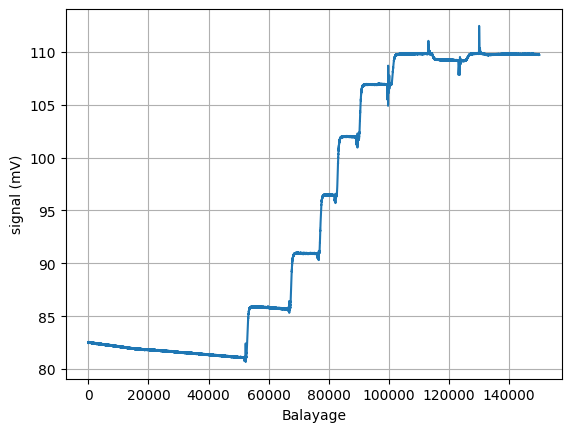

In [21]:
plot_csv("Data\S5_15bar_77K.csv")

In [11]:
def detect_stable_stage(path, precision=0.1, window_size=100, plot=False) :
    data = pd.read_csv(path, index_col='Bal', delimiter=';')
    data_of_interest = data.columns[2]
    values = str_to_float_v(data[data_of_interest].values)

    n = len(values)
    variances = np.empty(n-window_size)
    means = np.empty(n-window_size)

    # print(values)
    
    for i in range(n - window_size):
        window_data = values[i:i+window_size]
        var = np.var(window_data)
        mean = np.mean(window_data)
        variances[i] = var
        means[i] = mean
        
    points_stage = np.where(variances < precision)[0]
    points_stage_by_stage = np.split(points_stage, np.where(np.diff(points_stage) != 1)[0]+1)
    nb_stages = len(points_stage_by_stage)
    # print(nb_stages)
    stages_matrix = np.empty((nb_stages,4))
    # print(np.amin(points_stage_by_stage, axis=1))
    stages_matrix[:,0] = list(map(min,points_stage_by_stage))
    stages_matrix[:,1] = list(map(max,points_stage_by_stage))
    stages_matrix[:,2] = means[stages_matrix[:,0].astype(int)]
    stages_matrix[:,3] = variances[stages_matrix[:,0].astype(int)]

    if plot :
        plt.plot(variances)
        plt.plot([precision]*(n-window_size),'r')
    return stages_matrix

In [23]:
detect_stable_stage("Data\S5_15bar_77K.csv",precision=0.05,window_size=10)

array([[0.00000000e+00, 5.23410000e+04, 8.24687781e+01, 6.58241675e-04],
       [5.23570000e+04, 6.68390000e+04, 8.08255074e+01, 3.40174514e-02],
       [6.68530000e+04, 8.22000000e+04, 8.56636978e+01, 3.59065140e-02],
       [8.22070000e+04, 8.95200000e+04, 9.58402459e+01, 3.67602399e-02],
       [8.95270000e+04, 9.96940000e+04, 1.01113859e+02, 4.79770374e-02],
       [9.97050000e+04, 9.97160000e+04, 1.04990020e+02, 1.81133583e-02],
       [9.97380000e+04, 9.97490000e+04, 1.08537988e+02, 2.99018561e-02],
       [9.97550000e+04, 1.00093000e+05, 1.07775965e+02, 4.77568513e-02],
       [1.00102000e+05, 1.23569000e+05, 1.07659630e+02, 1.67135857e-02],
       [1.23575000e+05, 1.29995000e+05, 1.08096786e+02, 4.59158693e-02],
       [1.30002000e+05, 1.49995000e+05, 1.12131479e+02, 4.09565518e-02]])

In [17]:
def stables_stage_csv(path, precision=0.1, window_size=100):
    stages_matrix = detect_stable_stage(path, precision, window_size)
    nb_stages = len(stages_matrix)
    ind = np.arange(nb_stages)
    df = pd.DataFrame(stages_matrix, index=ind, columns=['Debut','Fin','Moyenne','Variance'])
    df.to_csv('Plot\\mat_'+new_name(path,'csv'))
    return df

In [24]:
stables_stage_csv("Data\Calne.csv",precision=0.05,window_size=300)

,Debut,Fin,Moyenne,Variance
0,0.0,1504.0,19.932160,8.497344e-04
1,2613.0,5106.0,0.228577,4.904633e-02
2,6213.0,8709.0,-19.688857,4.923069e-02
3,9805.0,12317.0,-39.566693,4.956794e-02
4,13451.0,19528.0,-59.407890,4.966164e-02
5,20913.0,26790.0,-79.126290,4.931640e-02
6,29344.0,34591.0,-93.180327,4.990832e-02
7,35348.0,41782.0,-89.707383,4.983086e-02
8,42492.0,48966.0,-69.791307,4.909813e-02
9,49592.0,56162.0,-49.900357,4.952034e-02
